**<center><h1>Speaker Classification with Deep Learning</h1></center>**
**<center><h2>Speech Technology Assignment 2023-24</h2></center>**
**<center><h3>Matthias Bartolo</h3></center>**

**<h3>1. Introduction</h3>**

<p>
<b>Speaker Identification (SID)</b>, is the task of determining a speaker's identity from a particular speech sample that has been chosen from a group of recognised speakers. Speech data from various speakers is gathered and used to train a model that represents the hypothetical speaker, or a model that learns to discriminate among speakers, in order to construct a SID system.
</p>

**<h3>2. Package Installation</h3>**

In [1]:
# !pip install librosa
# !pip install tensorflow
# !pip install keras
# !pip install matplotlib
# !pip install numpy
# !pip install pandas
# !pip install sklearn
# !pip install seaborn
# !pip install scipy

**<h3>3. Package Imports</h3>**

In [2]:
import os
import random
import librosa
import librosa.display
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
import warnings
from sklearn.preprocessing import LabelEncoder
from keras.utils import to_categorical
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score
import pandas as pd
import seaborn as sns
import pickle
import json

warnings.filterwarnings('ignore')

# Declaring constants
# Sample rate is the number of samples of audio carried per second, measured in Hz or kHz (one kHz being 1000 Hz).
SAMPLE_RATE = 16000
# The number of melodies to extract from each audio chunk
N_MELS = 128
# The number of mel-spectrogram frames to extract from each audio chunk
MEL_SPEC_FRAME_SIZE = 1024
# The number of speakers/classes in the dataset
NUM_CLASSES = 285
# Mel-spectrogram flag
MEL_SPECTROGRAM = "Mel Spectrogram"
# MFCC flag
MFCC = "MFCC"

**<h3>4. Loading and Filtering Dataset</h3>**

**<h4>Function to get the list of speaker roots in the data path</h4>**

In [3]:
def get_speaker_roots_in_data_path(datapath=os.path.join(os.getcwd(), 'ABI-1 Corpus\\accents')):
    """Function to get the list of speaker roots in the data path.
    
    Args:
        datapath (str): Path to the data folder.

    Returns:
        speaker_list (list): List of speaker roots in the data path.
    """
    # Declaring the list of speakers
    speaker_list = []

    # Retrieving the list of accent subfolders
    accent_subfolders = [f.path for f in os.scandir(datapath) if f.is_dir()]
    
    # Iterating through the accent subfolders
    for accent in accent_subfolders:
        # Iterating through the gender
        for gender in ['female', 'male']:
            # Retrieving the list of speaker folders
            speaker_folders = os.listdir(os.path.join(accent, gender))
            
            # Iterating through the speaker folders
            for speaker in speaker_folders:
                # Checking if the speaker folder is not a hidden folder
                if not speaker.startswith('.'):
                    speaker_list.append(os.path.join(accent, gender, speaker))
    
    # Returning the list of speakers
    return speaker_list

**<h4>Function to get the list of wav files in the data path</h4>**

In [4]:
def get_wav_files_in_path(datapath):
    """Function to get the list of wav files in the data path.

    Args:
        datapath (str): Path to the data folder.
    
    Returns:
        wav_files (list): List of wav files in the data path.
    """
    # Retrieving the list of files in the data path
    files = os.listdir(datapath)

    # Filtering the list of files to get only the wav files which are shortpassage files
    wav_files = [f for f in files if f.endswith('.wav') and 'shortpassage' in f]

    # Appending the path to the wav files
    wav_files = [os.path.join(datapath, f) for f in wav_files]
    
    # Returning the list of wav files
    return wav_files

In [5]:
# Retrieving the list of speaker roots in the data path
speaker_roots = get_speaker_roots_in_data_path()
print('\033[1m' + 'Number of speakers found: ' + '\033[0m' + str(len(speaker_roots)))

# Retrieving the list of wav files in the data path
wav_files = []

# Iterating through the speaker roots
for speaker_root in speaker_roots:
    # Retrieving the list of wav files in the speaker root
    wav_files.extend(get_wav_files_in_path(speaker_root))

print('\033[1m' + 'Number of shortpassage wav files found: ' + '\033[0m' + str(len(wav_files)))

# Setting the number of classes
NUM_CLASSES = len(speaker_roots)

Number of speakers found: 285
Number of shortpassage wav files found: 855


**<h3>5. Preprocessing Data, Chunking and Dataset Splitting</h3>**

**<h4>Function to display the spectrogram</h4>**

In [6]:
def display_spectrogram(spectrogram, sampling_rate=SAMPLE_RATE, y_axis='mel', title='Linear Spectrogram'):
    """Function to display the spectrogram.
    
    Args:
        spectrogram (numpy.ndarray): Spectrogram to be displayed.
        sampling_rate (int): Sampling rate of the audio (default is 16000).
        y_axis (str): Type of y-axis to be displayed (default is linear).
        title (str): Title of the plot (default is Linear Spectrogram).
    """
    # Setting the figure size
    plt.figure(figsize=(20, 8))

    # Setting the title
    plt.xlabel('Time')

    # Setting the y-axis
    plt.ylabel('Mel-Frequency')
    
    # Displaying the spectrogram
    librosa.display.specshow(spectrogram,
                            y_axis=y_axis,
                            fmax=sampling_rate / 2,
                            sr=sampling_rate,
                            hop_length=int(MEL_SPEC_FRAME_SIZE / 2),
                            x_axis='time')
    
    # Displaying the colorbar
    plt.colorbar(format='%+2.0f dB')
    
    # Displaying the title
    plt.title(title)
    
    # Displaying the plot
    plt.show()

**<h4>Function to chunk the audio file into specified-second segments</h4>**

In [7]:
def chunk_audio(audio_path, chunk_size=3, plot=False, feature_extractor=MEL_SPECTROGRAM):
    """Function to chunk the audio file into specified-second segments.
    
    Args:
        audio_path (str): Path to the audio file.
        chunk_size (int): Duration of each audio chunk in seconds (default is 3 seconds).
        plot (bool): Flag to plot the audio chunks (default is False).
        feature_extractor (int): Flag to indicate the feature extractor to be used (default is MEL_SPECTROGRAM).
    
    Returns:
        audio_chunks (list): List of audio chunks.
    """
    # Reading the audio file, whilst ensuring the sampling rate is 16kHz
    audio, sampling_rate = librosa.load(audio_path, sr=SAMPLE_RATE)

    # Preprocessing the audio by normalizing the audio
    audio /= np.max(np.abs(audio), axis=0)
    
    # Calculating the number of samples per chunk
    samples_per_chunk = int(sampling_rate * chunk_size)
    
    # Calculating the number of chunks
    num_chunks = int(np.floor(len(audio) / samples_per_chunk))
    
    # Initializing the list of audio chunks
    audio_chunks = []
    
    # Iterating through the audio chunks
    for i in range(num_chunks):
        # Calculating the start and end sample
        start_sample = i * samples_per_chunk
        end_sample = (i + 1) * samples_per_chunk

        # Calculating the audio chunk
        audio_chunk = audio[start_sample:end_sample]

        if feature_extractor == MFCC:
            # Extracting the MFCCs using librosa
            mfcc = librosa.feature.mfcc(y=audio_chunk, 
                                        sr=sampling_rate,
                                        n_fft=MEL_SPEC_FRAME_SIZE,
                                        hop_length=int(MEL_SPEC_FRAME_SIZE / 2),
                                        n_mfcc=N_MELS)

            # Setting the spectrogram to be the MFCCs
            spectrogram = mfcc
        else:
            # Extracting the mel spectrogram using librosa
            mel_spectrogram = librosa.feature.melspectrogram(y=audio_chunk, 
                                                            sr=sampling_rate,
                                                            center=True,
                                                            n_fft=MEL_SPEC_FRAME_SIZE,
                                                            hop_length=int(MEL_SPEC_FRAME_SIZE / 2),
                                                            n_mels=N_MELS)

            # Converting the raw amplitude results to decibels (log scale)
            mel_spectrogram = librosa.power_to_db(mel_spectrogram, ref=1.0)

            # Setting the spectrogram to be the mel spectrogram
            spectrogram = mel_spectrogram

        # Plotting the spectrogram
        if plot:
            display_spectrogram(spectrogram, sampling_rate=sampling_rate, title='Mel Spectrogram of Audio Chunk ' + str(i + 1))

        # Appending the audio chunk to the list of audio chunks
        audio_chunks.append(spectrogram)
    
    # Returning the list of audio chunks
    return audio_chunks

**<h4>Function to preprocess, chunk and split the data</h4>**

In [8]:
def preprocess_data(speaker_roots, training_set_ratio, validation_set_ratio, testing_set_ratio, do_display=False, do_save=False, plot=False, feature_extractor=MEL_SPECTROGRAM):
    """"Function to preprocess, chunk and split the data.

    Args:
        speaker_roots (list): List of speaker roots in the data path.
        training_set_ratio (float): Ratio of the training set.
        validation_set_ratio (float): Ratio of the validation set.
        testing_set_ratio (float): Ratio of the testing set.
        do_display (bool): Boolean to display the audio chunks (default is False).
        do_save (bool): Boolean to save the audio chunks (default is False).
        plot (bool): Boolean to plot the spectrogram (default is False).
        feature_extractor (int): Flag to indicate the feature extractor to be used (default is MEL_SPECTROGRAM).

    Returns:
        training_set (list): List of training examples.
        validation_set (list): List of validation examples.
        testing_set (list): List of testing examples.
    """
    # Error checking for the ratios
    if training_set_ratio + validation_set_ratio + testing_set_ratio != 1:
        raise ValueError('The sum of the ratios must be equal to 1.')
    
    # Creating dictionary to store the speak to utterances mapping
    speaker_to_utterances = {}

    # Retrieving the list of speakers through the speaker roots, and giving each speaker a unique ID, since one of the speakers has the same name
    speakers ={speaker_root.split('\\')[-1]+str(unique_id): speaker_root for unique_id, speaker_root in enumerate(speaker_roots)}
  
    # Iterating through the speakers
    for speaker, speaker_root in speakers.items():
        if do_display:
            # Printing the speaker being processed
            print_message = '\033[32m' + 'Executing Speaker: ' + '\033[0m' + speaker + '\t {} / {}'.format(speaker_roots.index(speaker_root) + 1, len(speaker_roots))
            print(print_message)
            print('-' * len(print_message))

        # Retrieving the list of wav files in the speaker root
        speaker_wav_files = get_wav_files_in_path(speaker_root)
        
        # Initializing the list of utterances
        utterances = []
        
        # Iterating through the wav files
        for wav_file in speaker_wav_files:
            # Chunking the audio file into 3 seconds segments
            utterances.extend(chunk_audio(wav_file, plot=plot, feature_extractor=feature_extractor))
        
        # Appending the list of utterances to the dictionary
        speaker_to_utterances[speaker] = utterances

    # Shuffling the utterances
    for speaker, utterances in speaker_to_utterances.items():
        random.shuffle(utterances)

    # Splitting the utterances into training, validation and testing sets
    training_set = []
    validation_set = []
    testing_set = []

    # Iterating through the speakers
    for speaker in speaker_to_utterances:
        # Retrieving the list of utterances
        utterances = speaker_to_utterances[speaker]

        # Calculating the number of utterances for each set
        num_training_utterances = int(len(utterances) * training_set_ratio)
        num_validation_utterances = int(len(utterances) * validation_set_ratio)

        # Appending the utterances to the relevant sets
        training_set.extend([(utterance, speaker) for utterance in utterances[:num_training_utterances]])
        validation_set.extend([(utterance, speaker) for utterance in utterances[num_training_utterances:num_training_utterances + num_validation_utterances]])
        testing_set.extend([(utterance, speaker) for utterance in utterances[num_training_utterances + num_validation_utterances:]])

    # Shuffling the relevant sets
    random.shuffle(training_set)
    random.shuffle(validation_set)
    random.shuffle(testing_set)

    # Displaying the number of utterances in each set
    if do_display:
        print('\033[35m' + 'Percentage of utterances in each set:' + '\033[0m')
        print('\033[35m' + 'Training Set: ' + '\033[0m' + '{:.2%}'.format(len(training_set) / sum([len(utterances) for utterances in speaker_to_utterances.values()])))
        print('\033[35m' + 'Validation Set: ' + '\033[0m' + '{:.2%}'.format(len(validation_set) / sum([len(utterances) for utterances in speaker_to_utterances.values()])))
        print('\033[35m' + 'Testing Set: ' + '\033[0m' + '{:.2%}'.format(len(testing_set) / sum([len(utterances) for utterances in speaker_to_utterances.values()])))

    # Saving the training, validation and testing sets in a pickle file
    if do_save:
        # Saving the file in a folder called 'filtered_data' with the feature extractor name
        if not os.path.exists('filtered_data'):
            os.makedirs('filtered_data')

        # Saving the file in a folder called 'filtered_data' with the feature extractor name
        if not os.path.exists(os.path.join('filtered_data', feature_extractor)):
            os.makedirs(os.path.join('filtered_data', feature_extractor))

        # Saving the training, validation and testing sets in a pickle file
        with open(os.path.join('filtered_data', feature_extractor, 'training_set.pickle'), 'wb') as handle:
            pickle.dump(training_set, handle, protocol=pickle.HIGHEST_PROTOCOL)

        with open(os.path.join('filtered_data', feature_extractor, 'validation_set.pickle'), 'wb') as handle:
            pickle.dump(validation_set, handle, protocol=pickle.HIGHEST_PROTOCOL)
        
        with open(os.path.join('filtered_data', feature_extractor, 'testing_set.pickle'), 'wb') as handle:
            pickle.dump(testing_set, handle, protocol=pickle.HIGHEST_PROTOCOL)

    # Returning the relevant sets
    return training_set, validation_set, testing_set

**<h5>Preprocessing, chunking and splitting the data, based on the feature extraction method</h5>**

In [9]:
# Calling the preprocess_data function to preprocess, chunk and split the data, but using the mel spectrogram as the feature extractor
training_set_mel, validation_set_mel, testing_set_mel = preprocess_data(speaker_roots, 0.6, 0.2, 0.2, do_display=True, do_save=True, plot=False, feature_extractor=MEL_SPECTROGRAM)

Executing Speaker: alw0010	 1 / 285
--------------------------------------------
Executing Speaker: cxb0011	 2 / 285
--------------------------------------------
Executing Speaker: jah0012	 3 / 285
--------------------------------------------
Executing Speaker: jep0013	 4 / 285
--------------------------------------------
Executing Speaker: knb0014	 5 / 285
--------------------------------------------
Executing Speaker: lcg0015	 6 / 285
--------------------------------------------
Executing Speaker: lst0016	 7 / 285
--------------------------------------------
Executing Speaker: mjd0017	 8 / 285
--------------------------------------------
Executing Speaker: mpt0018	 9 / 285
--------------------------------------------
Executing Speaker: rkk0019	 10 / 285
---------------------------------------------
Executing Speaker: ajh00110	 11 / 285
----------------------------------------------
Executing Speaker: apd00111	 12 / 285
----------------------------------------------
Executing Speaker:

In [10]:
# Calling the preprocess_data function to preprocess, chunk and split the data, but using the MFCCs as the feature extractor
training_set_mfcc, validation_set_mfcc, testing_set_mfcc = preprocess_data(speaker_roots, 0.6, 0.2, 0.2, do_display=True, do_save=True, plot=False, feature_extractor=MFCC)

Executing Speaker: alw0010	 1 / 285
--------------------------------------------
Executing Speaker: cxb0011	 2 / 285
--------------------------------------------
Executing Speaker: jah0012	 3 / 285
--------------------------------------------
Executing Speaker: jep0013	 4 / 285
--------------------------------------------
Executing Speaker: knb0014	 5 / 285
--------------------------------------------
Executing Speaker: lcg0015	 6 / 285
--------------------------------------------
Executing Speaker: lst0016	 7 / 285
--------------------------------------------
Executing Speaker: mjd0017	 8 / 285
--------------------------------------------
Executing Speaker: mpt0018	 9 / 285
--------------------------------------------
Executing Speaker: rkk0019	 10 / 285
---------------------------------------------
Executing Speaker: ajh00110	 11 / 285
----------------------------------------------
Executing Speaker: apd00111	 12 / 285
----------------------------------------------
Executing Speaker:

**<h4>Function to load the filtered data</h4>**

In [11]:
def load_filtered_data(path):
    """Function to load the filtered data.

    Args:
        path (str): Path to the folder containing the filtered data.

    Returns:
        training_set (list): List of training examples.
        validation_set (list): List of validation examples.
        testing_set (list): List of testing examples.
    """
    # Loading the training, validation and testing sets from the pickle files
    with open(os.path.join(path, 'training_set.pickle'), 'rb') as handle:
        training_set = pickle.load(handle)

    with open(os.path.join(path, 'validation_set.pickle'), 'rb') as handle:
        validation_set = pickle.load(handle)

    with open(os.path.join(path, 'testing_set.pickle'), 'rb') as handle:
        testing_set = pickle.load(handle)

    # Extracting the number of labels in training set
    num_train_labels = len(set([label for _, label in training_set]))

    # Extracting the number of labels in validation set
    num_val_labels = len(set([label for _, label in validation_set]))

    # Extracting the number of labels in testing set
    num_test_labels = len(set([label for _, label in testing_set]))

    # Printing the number of labels in each set
    print('\033[35m' + 'Number of labels in each set:' + '\033[0m')
    print('\033[35m' + 'Training Set: ' + '\033[0m' + str(num_train_labels))
    print('\033[35m' + 'Validation Set: ' + '\033[0m' + str(num_val_labels))
    print('\033[35m' + 'Testing Set: ' + '\033[0m' + str(num_test_labels))

    # Error checking for the number of labels
    assert num_train_labels == num_val_labels == num_test_labels == NUM_CLASSES, 'The number of labels in each set must be equal to the number of classes.'
    print('=' * 100)
    print('\033[32m' + 'The number of labels in each set is equal to the number of classes.' + '\033[0m')

    # Returning the relevant sets
    return training_set, validation_set, testing_set

**<h5>Loading the filtered data</h5>**

In [12]:
# Loading the training, validation and testing sets from the pickle file for the mel spectrogram
training_set_mel, validation_set_mel, testing_set_mel = load_filtered_data(os.path.join('filtered_data', MEL_SPECTROGRAM))

print('*'*100)

# Loading the training, validation and testing sets from the pickle file for the MFCCs
training_set_mfcc, validation_set_mfcc, testing_set_mfcc = load_filtered_data(os.path.join('filtered_data', MFCC))

Number of labels in each set:
Training Set: 285
Validation Set: 285
Testing Set: 285
The number of labels in each set is equal to the number of classes.
****************************************************************************************************
Number of labels in each set:
Training Set: 285
Validation Set: 285
Testing Set: 285
The number of labels in each set is equal to the number of classes.


**<h4>Function to encode the data, and convert them to numpy arrays</h4>**

In [13]:
def encode_data(training_set, validation_set, testing_set):
    """Function to encode the data, and convert them to numpy arrays.

    Args:
        training_set (list): List of training examples.
        validation_set (list): List of validation examples.
        testing_set (list): List of testing examples.

    Returns:
        x_train (numpy.ndarray): Training set.
        y_train_encoded (numpy.ndarray): Encoded training labels.
        x_val (numpy.ndarray): Validation set.
        y_val_encoded (numpy.ndarray): Encoded validation labels.
        x_test (numpy.ndarray): Testing set.
        y_test_encoded (numpy.ndarray): Encoded testing labels.
    """
    # Preparing the training, validation and testing sets in the format required by the model, and converting them to numpy arrays
    x_train = np.array([utterance for utterance, speaker in training_set])
    y_train = np.array([speaker for utterance, speaker in training_set])

    x_val = np.array([utterance for utterance, speaker in validation_set])
    y_val = np.array([speaker for utterance, speaker in validation_set])

    x_test = np.array([utterance for utterance, speaker in testing_set])
    y_test = np.array([speaker for utterance, speaker in testing_set])

    # Encoding the labels using LabelEncoder
    label_encoder = LabelEncoder()

    # Fitting and transforming labels for training data
    y_train_encoded = label_encoder.fit_transform(y_train)
    # Transforming labels for validation and testing data
    y_val_encoded = label_encoder.transform(y_val)
    y_test_encoded = label_encoder.transform(y_test)

    # One-hot encoding the transformed labels
    # Converting encoded labels to one-hot encoding
    y_train_encoded = to_categorical(y_train_encoded)
    y_val_encoded = to_categorical(y_val_encoded)
    y_test_encoded = to_categorical(y_test_encoded)

    # Returning the relevant sets
    return x_train, y_train_encoded, x_val, y_val_encoded, x_test, y_test_encoded

**<h5>Encoding the data, and converting them to numpy arrays</h5>**

In [14]:
# Preparing the training, validation and testing sets in the format required by the model, and converting them to numpy arrays for the mel spectrogram
x_train_mel, y_train_encoded_mel, x_val_mel, y_val_encoded_mel, x_test_mel, y_test_encoded_mel = encode_data(training_set_mel, validation_set_mel, testing_set_mel)

# Preparing the training, validation and testing sets in the format required by the model, and converting them to numpy arrays for the MFCCs
x_train_mfcc, y_train_encoded_mfcc, x_val_mfcc, y_val_encoded_mfcc, x_test_mfcc, y_test_encoded_mfcc = encode_data(training_set_mfcc, validation_set_mfcc, testing_set_mfcc)

**<h3>6. Speaker Identification (SID) Model Design and Implementation</h3>**

**<h4>Function to plot the training and validation curves for the specified metric</h4>**

In [15]:
def plot_curves(history, metric, title, colors=['blue', 'cyan', 'green', 'purple'], marker='o', do_save=False, save_path=None):
    """Function to plot the training and validation curves for the specified metric.
    
    Args:
        history (keras.callbacks.History): History of the model.
        metric (str): Metric to be plotted.
        title (str): Title of the plot.
        colors (list): List of colors for the training and validation curves (default is ['blue', 'cyan', 'green', 'purple']).
        marker (str): Marker for the best validation score (default is 'o').
        do_save (bool): Flag to save the plot (default is False).
        save_path (str): Path to save the plot (default is None).
    """
    # Retrieving the metric values
    metric_train = history.history[metric]
    metric_val = history.history['val_' + metric]
    metric_loss = history.history['loss']
    metric_val_loss = history.history['val_loss']

    # Retrieving the number of epochs
    epochs = range(len(metric_train))

    # Plotting results
    plt.figure(figsize=(10, 7))
    plt.plot(epochs, metric_train, label='Training ' + metric.title(), color=colors[0], marker=marker)
    plt.plot(epochs, metric_val, label='Validation ' + metric.title(), color=colors[1], marker=marker)
    plt.plot(epochs, metric_loss, label='Training ' + 'Loss', color=colors[2], marker=marker)
    plt.plot(epochs, metric_val_loss, label='Validation ' + 'Loss', color=colors[3], marker=marker)
    plt.axvline(np.argmax(metric_val), linestyle='--', color='red', label='Best Val '+metric.title()+':' + str(round(np.max(metric_val), 2)))
    plt.title(title)
    plt.xlabel('Epoch')
    plt.ylabel('Loss/'+metric.title())
    plt.grid()
    plt.legend(loc = 'upper right')
    plt.tight_layout()

    # Saving the plot
    if do_save:
        # Saving the file in a folder called 'plots'
        if not os.path.exists('plots'):
            os.makedirs('plots')

        # Saving the plot
        plt.savefig(os.path.join('plots', save_path))

    # Displaying the plot    
    plt.show()

**<h4>Defining Different Model Architectures</h4>**

In [79]:
# Resetting Keras Session
keras.backend.clear_session()

**<h4> Model 1: Base CNN followed by LSTM (CNN-LSTM)</h4>**

In [80]:
# Defining the model architecture
model1 = keras.Sequential([
    keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(128, 94, 1)),
    keras.layers.Conv2D(64, (3, 3), activation='relu'),
    keras.layers.MaxPooling2D(pool_size=(2, 2)),
    keras.layers.Conv2D(64, (3, 3), activation='relu'),
    keras.layers.MaxPooling2D(pool_size=(2, 2)),
    keras.layers.Reshape((30, 21 * 64)),
    keras.layers.LSTM(64, return_sequences=True),
    keras.layers.Flatten(),
    keras.layers.BatchNormalization(),
    keras.layers.Dropout(0.3),
    keras.layers.Dense(NUM_CLASSES, activation='softmax')
])

# Setting the optimizer
optimizer1 = keras.optimizers.Adam(learning_rate=0.0005)

# Early stopping callback
early_stopping1 = keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Compiling the model
model1.compile(optimizer=optimizer1,
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Printing the model summary
model1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 126, 92, 32)       320       
                                                                 
 conv2d_1 (Conv2D)           (None, 124, 90, 64)       18496     
                                                                 
 max_pooling2d (MaxPooling2  (None, 62, 45, 64)        0         
 D)                                                              
                                                                 
 conv2d_2 (Conv2D)           (None, 60, 43, 64)        36928     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 30, 21, 64)        0         
 g2D)                                                            
                                                                 
 reshape (Reshape)           (None, 30, 1344)          0

**<h4> Model 2: Increased Convolutional Layers</h4>**

In [81]:
# Defining the model architecture
model2 = keras.Sequential([
    keras.layers.Conv2D(64, (3, 3), activation='relu', input_shape=(128, 94, 1)),
    keras.layers.Conv2D(128, (3, 3), activation='relu'),  # Increased depth
    keras.layers.MaxPooling2D(pool_size=(2, 2)),
    keras.layers.Conv2D(128, (3, 3), activation='relu'),  # Maintaining the depth
    keras.layers.MaxPooling2D(pool_size=(2, 2)),
    keras.layers.Reshape((30, 21 * 128)),
    keras.layers.LSTM(64, return_sequences=True),
    keras.layers.Flatten(),
    keras.layers.BatchNormalization(),
    keras.layers.Dropout(0.3),
    keras.layers.Dense(NUM_CLASSES, activation='softmax')
])

# Setting the optimizer
optimizer2 = keras.optimizers.Adam(learning_rate=0.0005)

# Early stopping callback
early_stopping2 = keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Compiling the model
model2.compile(optimizer=optimizer2,
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Printing the model summary
model2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 126, 92, 64)       640       
                                                                 
 conv2d_4 (Conv2D)           (None, 124, 90, 128)      73856     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 62, 45, 128)       0         
 g2D)                                                            
                                                                 
 conv2d_5 (Conv2D)           (None, 60, 43, 128)       147584    
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 30, 21, 128)       0         
 g2D)                                                            
                                                                 
 reshape_1 (Reshape)         (None, 30, 2688)         

**<h4> Model 3: Altered LSTM Configuration</h4>**

In [82]:
# Defining the model architecture
model3 = keras.Sequential([
    keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(128, 94, 1)),
    keras.layers.Conv2D(64, (3, 3), activation='relu'),
    keras.layers.MaxPooling2D(pool_size=(2, 2)),
    keras.layers.Conv2D(64, (3, 3), activation='relu'),
    keras.layers.MaxPooling2D(pool_size=(2, 2)),
    keras.layers.Reshape((30, 21 * 64)),
    keras.layers.LSTM(128, return_sequences=True),  # Increased LSTM units
    keras.layers.LSTM(64, return_sequences=True),  # Additional LSTM layer
    keras.layers.Flatten(),
    keras.layers.BatchNormalization(),
    keras.layers.Dropout(0.3),
    keras.layers.Dense(NUM_CLASSES, activation='softmax')
])

# Setting the optimizer
optimizer3 = keras.optimizers.Adam(learning_rate=0.0005)

# Early stopping callback
early_stopping3 = keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Compiling the model
model3.compile(optimizer=optimizer3,
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Printing the model summary
model3.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 126, 92, 32)       320       
                                                                 
 conv2d_7 (Conv2D)           (None, 124, 90, 64)       18496     
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 62, 45, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_8 (Conv2D)           (None, 60, 43, 64)        36928     
                                                                 
 max_pooling2d_5 (MaxPoolin  (None, 30, 21, 64)        0         
 g2D)                                                            
                                                                 
 reshape_2 (Reshape)         (None, 30, 1344)         

**<h4> Model 4: Additional Dense Layer</h4>**

In [83]:
# Defining the model architecture
model4 = keras.Sequential([
    keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(128, 94, 1)),
    keras.layers.Conv2D(64, (3, 3), activation='relu'),
    keras.layers.MaxPooling2D(pool_size=(2, 2)),
    keras.layers.Conv2D(64, (3, 3), activation='relu'),
    keras.layers.MaxPooling2D(pool_size=(2, 2)),
    keras.layers.Reshape((30, 21 * 64)),
    keras.layers.LSTM(64, return_sequences=True),
    keras.layers.Flatten(),
    keras.layers.Dense(128, activation='relu'),  # Additional dense layer
    keras.layers.BatchNormalization(),
    keras.layers.Dropout(0.3),
    keras.layers.Dense(NUM_CLASSES, activation='softmax')
])

# Setting the optimizer
optimizer4 = keras.optimizers.Adam(learning_rate=0.0005)

# Early stopping callback
early_stopping4 = keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Compiling the model
model4.compile(optimizer=optimizer4,
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Printing the model summary
model4.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_9 (Conv2D)           (None, 126, 92, 32)       320       
                                                                 
 conv2d_10 (Conv2D)          (None, 124, 90, 64)       18496     
                                                                 
 max_pooling2d_6 (MaxPoolin  (None, 62, 45, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_11 (Conv2D)          (None, 60, 43, 64)        36928     
                                                                 
 max_pooling2d_7 (MaxPoolin  (None, 30, 21, 64)        0         
 g2D)                                                            
                                                                 
 reshape_3 (Reshape)         (None, 30, 1344)         

**<h4> Model 5: Variant Convolutional Layers</h4>**

In [84]:
# Defining the model architecture
model5 = keras.Sequential([
    keras.layers.Conv2D(16, (3, 3), activation='relu', input_shape=(128, 94, 1)),  # Fewer filters
    keras.layers.Conv2D(32, (3, 3), activation='relu'),  # Fewer filters
    keras.layers.MaxPooling2D(pool_size=(2, 2)),
    keras.layers.Conv2D(64, (3, 3), activation='relu'),
    keras.layers.MaxPooling2D(pool_size=(2, 2)),
    keras.layers.Reshape((30, 21 * 64)),
    keras.layers.LSTM(64, return_sequences=True),
    keras.layers.Flatten(),
    keras.layers.BatchNormalization(),
    keras.layers.Dropout(0.3),
    keras.layers.Dense(NUM_CLASSES, activation='softmax')
])

# Setting the optimizer
optimizer5 = keras.optimizers.Adam(learning_rate=0.0005)

# Early stopping callback
early_stopping5 = keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Compiling the model
model5.compile(optimizer=optimizer5,
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Printing the model summary
model5.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_12 (Conv2D)          (None, 126, 92, 16)       160       
                                                                 
 conv2d_13 (Conv2D)          (None, 124, 90, 32)       4640      
                                                                 
 max_pooling2d_8 (MaxPoolin  (None, 62, 45, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_14 (Conv2D)          (None, 60, 43, 64)        18496     
                                                                 
 max_pooling2d_9 (MaxPoolin  (None, 30, 21, 64)        0         
 g2D)                                                            
                                                                 
 reshape_4 (Reshape)         (None, 30, 1344)         

**<h4> Model 6: Adding Batch Normalisation to each Convolutional Layer</h4>**

In [85]:
# Defining the model architecture
model6 = keras.Sequential([
    keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(128, 94, 1)),
    keras.layers.BatchNormalization(),  # Batch Normalization after first Conv2D layer
    keras.layers.Conv2D(64, (3, 3), activation='relu'),
    keras.layers.BatchNormalization(),  # Batch Normalization after second Conv2D layer
    keras.layers.MaxPooling2D(pool_size=(2, 2)),
    keras.layers.Conv2D(64, (3, 3), activation='relu'),
    keras.layers.BatchNormalization(),  # Batch Normalization after third Conv2D layer
    keras.layers.MaxPooling2D(pool_size=(2, 2)),
    keras.layers.Reshape((30, 21 * 64)),
    keras.layers.LSTM(64, return_sequences=True),
    keras.layers.Flatten(),
    keras.layers.BatchNormalization(),  # Batch Normalization before Dense layer
    keras.layers.Dropout(0.3),
    keras.layers.Dense(NUM_CLASSES, activation='softmax')
])

# Setting the optimizer
optimizer6 = keras.optimizers.Adam(learning_rate=0.0005)

# Early stopping callback
early_stopping6 = keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Compiling the model
model6.compile(optimizer=optimizer6,
               loss='categorical_crossentropy',
               metrics=['accuracy'])

# Printing the model summary
model6.summary()


Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_15 (Conv2D)          (None, 126, 92, 32)       320       
                                                                 
 batch_normalization_5 (Bat  (None, 126, 92, 32)       128       
 chNormalization)                                                
                                                                 
 conv2d_16 (Conv2D)          (None, 124, 90, 64)       18496     
                                                                 
 batch_normalization_6 (Bat  (None, 124, 90, 64)       256       
 chNormalization)                                                
                                                                 
 max_pooling2d_10 (MaxPooli  (None, 62, 45, 64)        0         
 ng2D)                                                           
                                                      

**<h4>Training Models</h4>**

**<h5>Training model 1 with the different feature extractors</h5>**

Epoch 1/100
246/246 [==============================] - 75s 301ms/step - loss: 5.6885 - accuracy: 0.0067 - val_loss: 5.6375 - val_accuracy: 0.0102
Epoch 2/100
246/246 [==============================] - 78s 319ms/step - loss: 5.5729 - accuracy: 0.0135 - val_loss: 8.4927 - val_accuracy: 0.0114
Epoch 3/100
246/246 [==============================] - 80s 326ms/step - loss: 2.8346 - accuracy: 0.4195 - val_loss: 1.2562 - val_accuracy: 0.6789
Epoch 4/100
246/246 [==============================] - 81s 330ms/step - loss: 0.3386 - accuracy: 0.9264 - val_loss: 2.3539 - val_accuracy: 0.5503
Epoch 5/100
246/246 [==============================] - 81s 331ms/step - loss: 0.1180 - accuracy: 0.9795 - val_loss: 0.2107 - val_accuracy: 0.9528
Epoch 6/100
246/246 [==============================] - 82s 333ms/step - loss: 0.0631 - accuracy: 0.9907 - val_loss: 0.2012 - val_accuracy: 0.9513
Epoch 7/100
246/246 [==============================] - 80s 326ms/step - loss: 0.0406 - accuracy: 0.9948 - val_loss: 0.7826 -

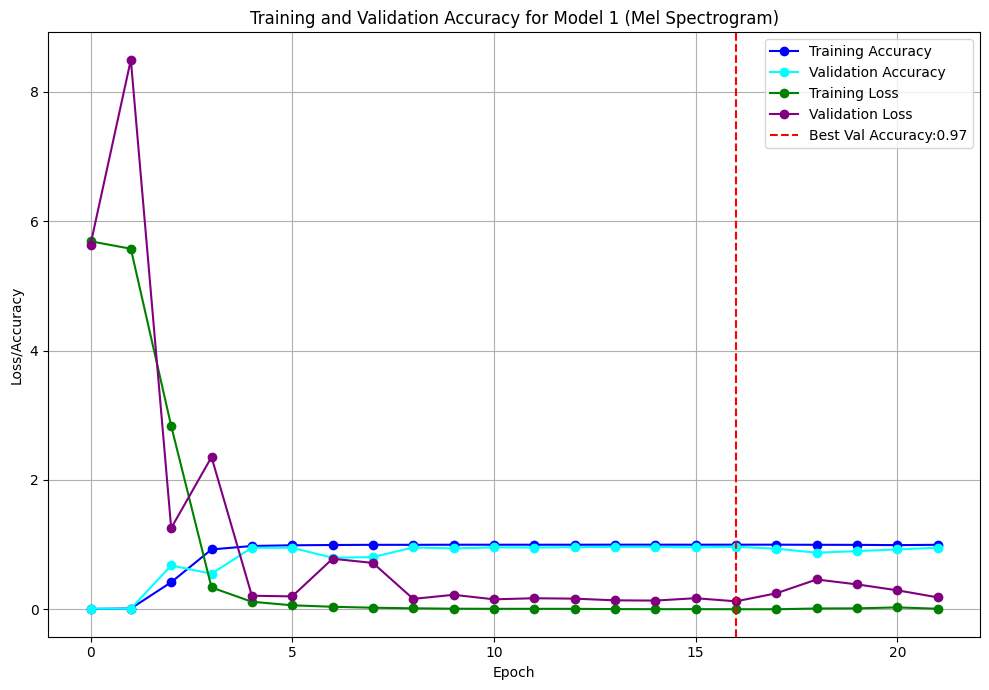

In [18]:
# Training model 1 on the mel spectrogram
history = model1.fit(x_train_mel, y_train_encoded_mel, validation_data=(x_val_mel, y_val_encoded_mel), epochs=100, batch_size=32, callbacks=[early_stopping1])

# Saving the model
model1.save('model1_mel.h5')

# Plotting the training and validation curves
plot_curves(history, 'accuracy', 'Training and Validation Accuracy for Model 1 (Mel Spectrogram)', do_save=True, save_path='model1_mel_accuracy.png')

Epoch 1/100
246/246 [==============================] - 83s 334ms/step - loss: 4.4263 - accuracy: 0.1221 - val_loss: 3.9637 - val_accuracy: 0.2410
Epoch 2/100
246/246 [==============================] - 97s 394ms/step - loss: 1.7115 - accuracy: 0.5856 - val_loss: 2.8182 - val_accuracy: 0.3447
Epoch 3/100
246/246 [==============================] - 98s 397ms/step - loss: 0.5442 - accuracy: 0.8896 - val_loss: 1.0557 - val_accuracy: 0.7178
Epoch 4/100
246/246 [==============================] - 92s 373ms/step - loss: 0.1664 - accuracy: 0.9795 - val_loss: 0.5609 - val_accuracy: 0.8546
Epoch 5/100
246/246 [==============================] - 93s 378ms/step - loss: 0.0740 - accuracy: 0.9926 - val_loss: 0.5364 - val_accuracy: 0.8679
Epoch 6/100
246/246 [==============================] - 94s 381ms/step - loss: 0.0389 - accuracy: 0.9981 - val_loss: 0.8356 - val_accuracy: 0.7744
Epoch 7/100
246/246 [==============================] - 94s 381ms/step - loss: 0.0245 - accuracy: 0.9994 - val_loss: 0.3514 -

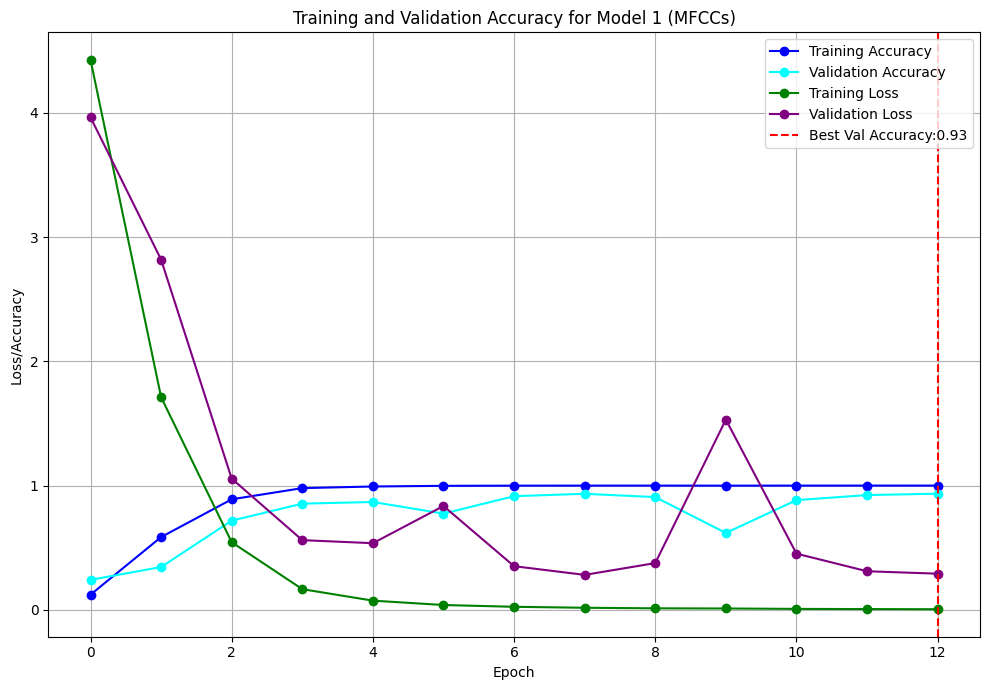

In [30]:
# Training model 1 on the MFCCs
history = model1.fit(x_train_mfcc, y_train_encoded_mfcc, validation_data=(x_val_mfcc, y_val_encoded_mfcc), epochs=100, batch_size=32, callbacks=[early_stopping1])

# Saving the model
model1.save('model1_mfcc.h5')

# Plotting the training and validation curves
plot_curves(history, 'accuracy', 'Training and Validation Accuracy for Model 1 (MFCCs)', do_save=True, save_path='model1_mfcc_accuracy.png')

**<h5>Training model 2 with the different feature extractors</h5>**

Epoch 1/100
246/246 [==============================] - 184s 746ms/step - loss: 5.6695 - accuracy: 0.0088 - val_loss: 5.6364 - val_accuracy: 0.0079
Epoch 2/100
246/246 [==============================] - 190s 774ms/step - loss: 5.6297 - accuracy: 0.0099 - val_loss: 5.7335 - val_accuracy: 0.0039
Epoch 3/100
246/246 [==============================] - 189s 770ms/step - loss: 5.6255 - accuracy: 0.0090 - val_loss: 5.6157 - val_accuracy: 0.0102
Epoch 4/100
246/246 [==============================] - 183s 743ms/step - loss: 5.6235 - accuracy: 0.0097 - val_loss: 5.6122 - val_accuracy: 0.0102
Epoch 5/100
246/246 [==============================] - 187s 762ms/step - loss: 5.6222 - accuracy: 0.0094 - val_loss: 5.6119 - val_accuracy: 0.0102
Epoch 6/100
246/246 [==============================] - 188s 764ms/step - loss: 5.6222 - accuracy: 0.0086 - val_loss: 5.6121 - val_accuracy: 0.0102
Epoch 7/100
246/246 [==============================] - 192s 782ms/step - loss: 5.6213 - accuracy: 0.0097 - val_loss: 5

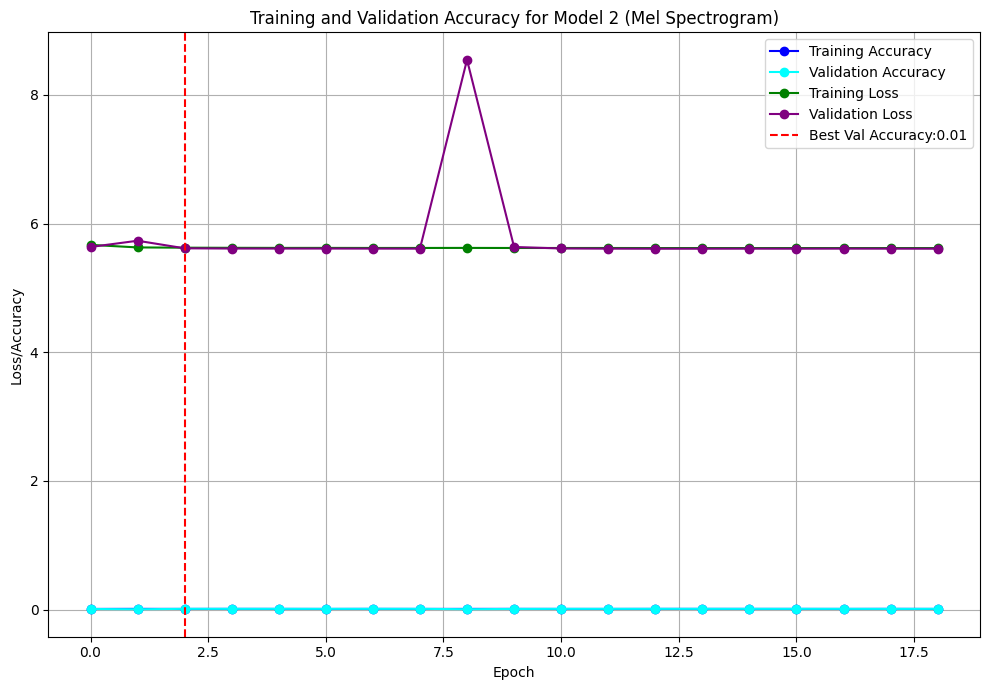

In [53]:
# Training model 2 on the mel spectrogram
history = model2.fit(x_train_mel, y_train_encoded_mel, validation_data=(x_val_mel, y_val_encoded_mel), epochs=100, batch_size=32, callbacks=[early_stopping2])

# Saving the model
model2.save('model2_mel.h5')

# Plotting the training and validation curves
plot_curves(history, 'accuracy', 'Training and Validation Accuracy for Model 2 (Mel Spectrogram)', do_save=True, save_path='model2_mel_accuracy.png')

Epoch 1/100
246/246 [==============================] - 190s 770ms/step - loss: 4.4871 - accuracy: 0.1164 - val_loss: 4.5682 - val_accuracy: 0.0472
Epoch 2/100
246/246 [==============================] - 198s 806ms/step - loss: 1.5793 - accuracy: 0.6326 - val_loss: 2.0262 - val_accuracy: 0.5047
Epoch 3/100
246/246 [==============================] - 204s 829ms/step - loss: 0.3897 - accuracy: 0.9259 - val_loss: 0.8254 - val_accuracy: 0.7842
Epoch 4/100
246/246 [==============================] - 191s 777ms/step - loss: 0.1065 - accuracy: 0.9876 - val_loss: 0.4376 - val_accuracy: 0.8911
Epoch 5/100
246/246 [==============================] - 191s 777ms/step - loss: 0.0468 - accuracy: 0.9962 - val_loss: 0.3733 - val_accuracy: 0.9119
Epoch 6/100
246/246 [==============================] - 193s 785ms/step - loss: 0.0261 - accuracy: 0.9989 - val_loss: 0.3310 - val_accuracy: 0.9230
Epoch 7/100
246/246 [==============================] - 195s 794ms/step - loss: 0.0156 - accuracy: 0.9997 - val_loss: 0

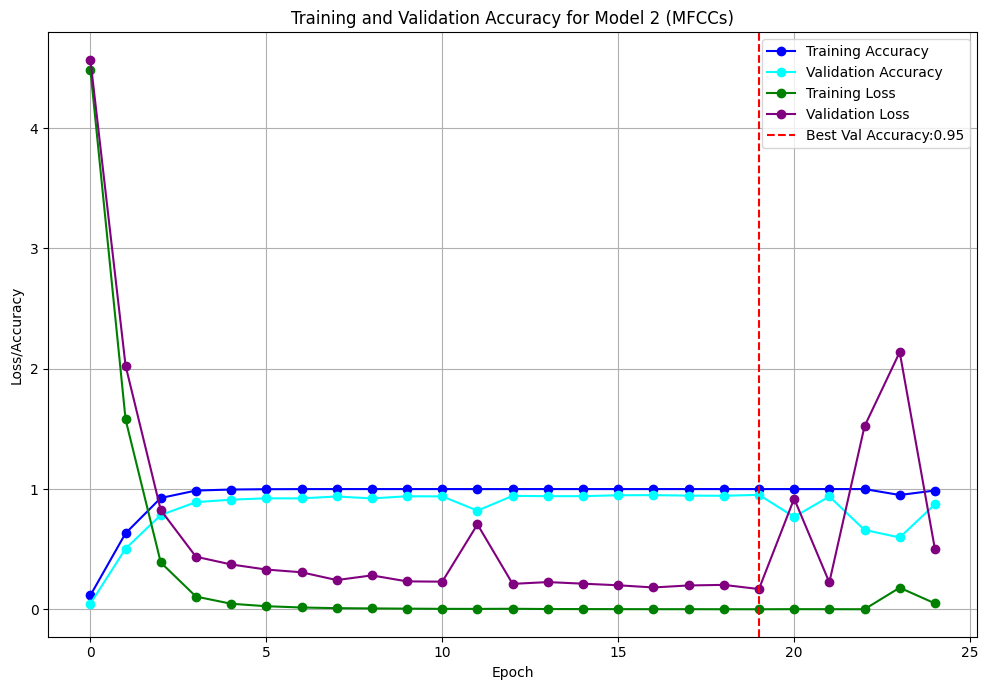

In [86]:
# Training model 2 on t he MFCCs
history = model2.fit(x_train_mfcc, y_train_encoded_mfcc, validation_data=(x_val_mfcc, y_val_encoded_mfcc), epochs=100, batch_size=32, callbacks=[early_stopping2])

# Saving the model
model2.save('model2_mfcc.h5')

# Plotting the training and validation curves
plot_curves(history, 'accuracy', 'Training and Validation Accuracy for Model 2 (MFCCs)', do_save=True, save_path='model2_mfcc_accuracy.png')

**<h5>Training model 3 with the different feature extractors</h5>**

Epoch 1/100
246/246 [==============================] - 89s 356ms/step - loss: 5.0311 - accuracy: 0.0682 - val_loss: 4.8915 - val_accuracy: 0.0763
Epoch 2/100
246/246 [==============================] - 85s 347ms/step - loss: 1.0719 - accuracy: 0.7567 - val_loss: 0.8614 - val_accuracy: 0.7968
Epoch 3/100
246/246 [==============================] - 87s 354ms/step - loss: 0.2767 - accuracy: 0.9466 - val_loss: 0.3615 - val_accuracy: 0.9061
Epoch 4/100
246/246 [==============================] - 87s 353ms/step - loss: 0.1441 - accuracy: 0.9709 - val_loss: 1.0736 - val_accuracy: 0.7205
Epoch 5/100
246/246 [==============================] - 89s 362ms/step - loss: 0.0980 - accuracy: 0.9813 - val_loss: 0.4438 - val_accuracy: 0.8821
Epoch 6/100
246/246 [==============================] - 86s 350ms/step - loss: 0.0601 - accuracy: 0.9893 - val_loss: 0.3735 - val_accuracy: 0.9025
Epoch 7/100
246/246 [==============================] - 86s 349ms/step - loss: 0.0485 - accuracy: 0.9906 - val_loss: 0.2640 -

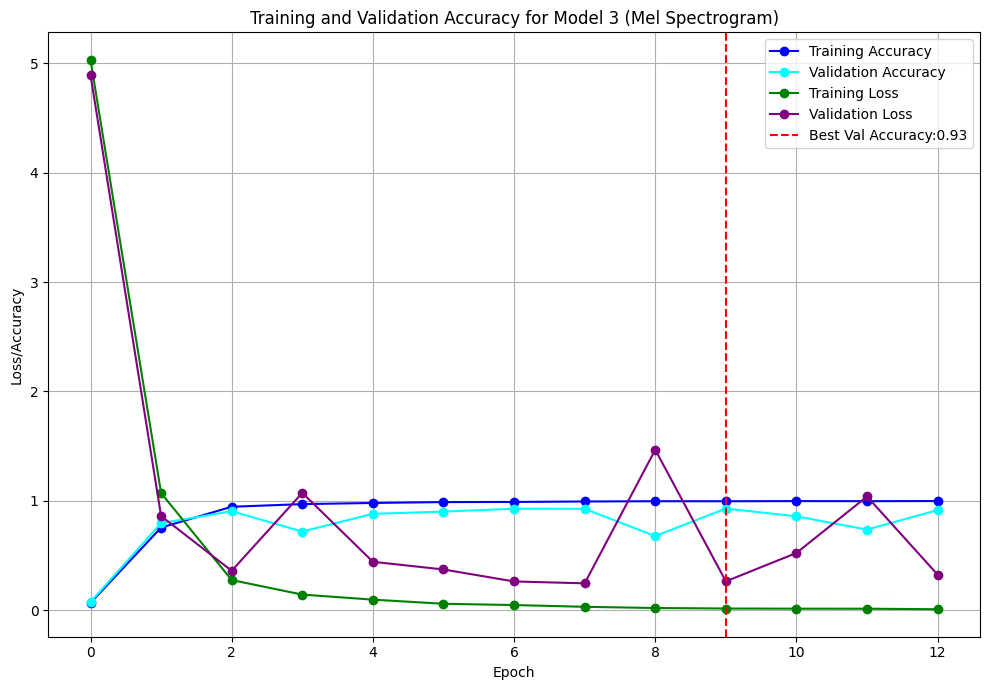

In [54]:
# Training model 3 on the mel spectrogram
history = model3.fit(x_train_mel, y_train_encoded_mel, validation_data=(x_val_mel, y_val_encoded_mel), epochs=100, batch_size=32, callbacks=[early_stopping3])

# Saving the model
model3.save('model3_mel.h5')

# Plotting the training and validation curves
plot_curves(history, 'accuracy', 'Training and Validation Accuracy for Model 3 (Mel Spectrogram)', do_save=True, save_path='model3_mel_accuracy.png')

Epoch 1/100
246/246 [==============================] - 104s 419ms/step - loss: 4.2240 - accuracy: 0.1359 - val_loss: 4.7104 - val_accuracy: 0.0562
Epoch 2/100
246/246 [==============================] - 112s 456ms/step - loss: 1.7696 - accuracy: 0.5540 - val_loss: 2.5618 - val_accuracy: 0.3640
Epoch 3/100
246/246 [==============================] - 120s 488ms/step - loss: 0.7479 - accuracy: 0.8195 - val_loss: 2.2021 - val_accuracy: 0.4733
Epoch 4/100
246/246 [==============================] - 121s 494ms/step - loss: 0.3220 - accuracy: 0.9327 - val_loss: 1.3880 - val_accuracy: 0.6380
Epoch 5/100
246/246 [==============================] - 121s 494ms/step - loss: 0.1572 - accuracy: 0.9695 - val_loss: 1.0101 - val_accuracy: 0.7351
Epoch 6/100
246/246 [==============================] - 119s 484ms/step - loss: 0.0839 - accuracy: 0.9870 - val_loss: 0.9117 - val_accuracy: 0.7543
Epoch 7/100
246/246 [==============================] - 120s 487ms/step - loss: 0.0456 - accuracy: 0.9950 - val_loss: 0

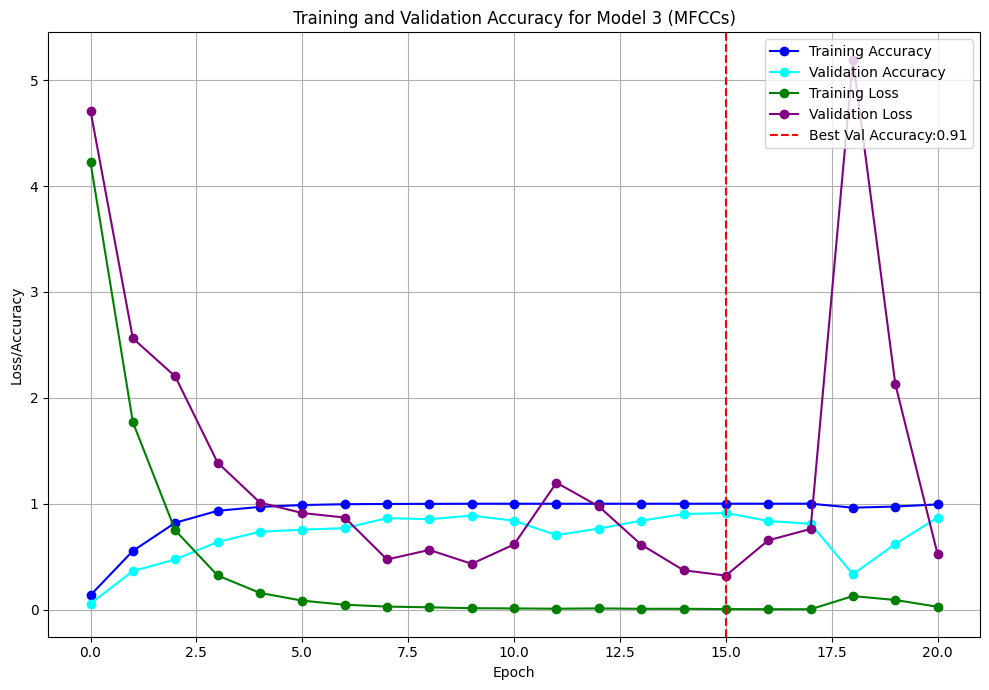

In [87]:
# Training model 3 on the MFCCs
history = model3.fit(x_train_mfcc, y_train_encoded_mfcc, validation_data=(x_val_mfcc, y_val_encoded_mfcc), epochs=100, batch_size=32, callbacks=[early_stopping3])

# Saving the model
model3.save('model3_mfcc.h5')

# Plotting the training and validation curves
plot_curves(history, 'accuracy', 'Training and Validation Accuracy for Model 3 (MFCCs)', do_save=True, save_path='model3_mfcc_accuracy.png')

**<h5>Training model 4 with the different feature extractors</h5>**

Epoch 1/100
246/246 [==============================] - 72s 285ms/step - loss: 5.6759 - accuracy: 0.0069 - val_loss: 5.6578 - val_accuracy: 0.0028
Epoch 2/100
246/246 [==============================] - 70s 287ms/step - loss: 5.5466 - accuracy: 0.0155 - val_loss: 7.0828 - val_accuracy: 0.0071
Epoch 3/100
246/246 [==============================] - 70s 286ms/step - loss: 4.8132 - accuracy: 0.0799 - val_loss: 8.7583 - val_accuracy: 0.0161
Epoch 4/100
246/246 [==============================] - 70s 286ms/step - loss: 3.6140 - accuracy: 0.3276 - val_loss: 3.3424 - val_accuracy: 0.2736
Epoch 5/100
246/246 [==============================] - 71s 287ms/step - loss: 2.4422 - accuracy: 0.6226 - val_loss: 3.5161 - val_accuracy: 0.2103
Epoch 6/100
246/246 [==============================] - 71s 287ms/step - loss: 1.5889 - accuracy: 0.8103 - val_loss: 1.3748 - val_accuracy: 0.8046
Epoch 7/100
246/246 [==============================] - 70s 286ms/step - loss: 1.0441 - accuracy: 0.8962 - val_loss: 1.2071 -

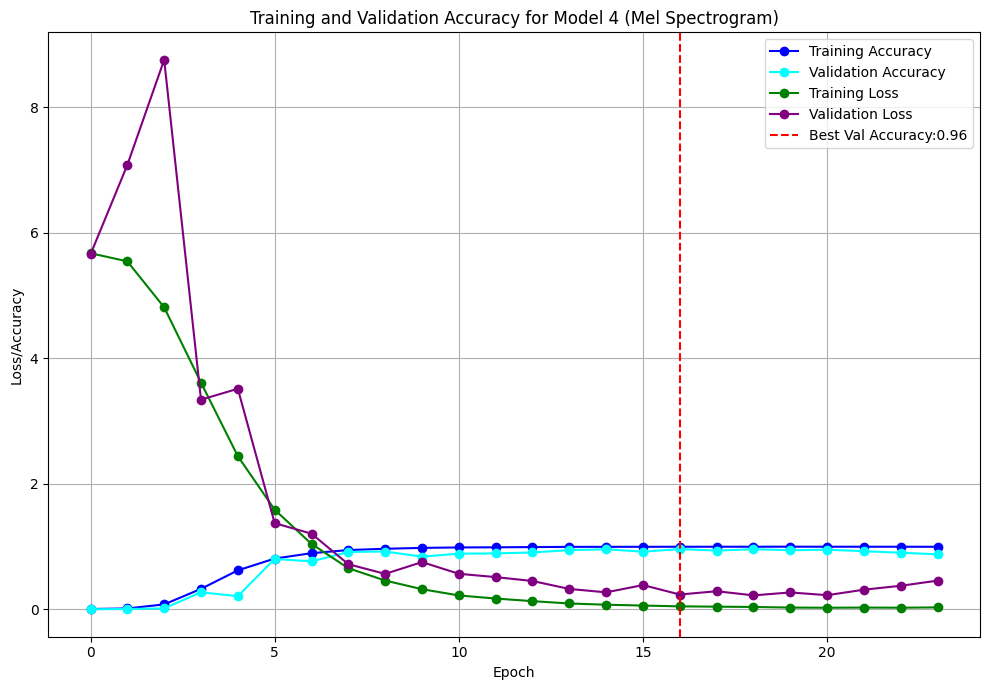

In [55]:
# Training model 4 on the mel spectrogram
history = model4.fit(x_train_mel, y_train_encoded_mel, validation_data=(x_val_mel, y_val_encoded_mel), epochs=100, batch_size=32, callbacks=[early_stopping4])

# Saving the model
model4.save('model4_mel.h5')

# Plotting the training and validation curves
plot_curves(history, 'accuracy', 'Training and Validation Accuracy for Model 4 (Mel Spectrogram)', do_save=True, save_path='model4_mel_accuracy.png')

In [ ]:
# Training model 4 on the MFCCs
history = model4.fit(x_train_mfcc, y_train_encoded_mfcc, validation_data=(x_val_mfcc, y_val_encoded_mfcc), epochs=100, batch_size=32, callbacks=[early_stopping4])

# Saving the model
model4.save('model4_mfcc.h5')

# Plotting the training and validation curves
plot_curves(history, 'accuracy', 'Training and Validation Accuracy for Model 4 (MFCCs)', do_save=True, save_path='model4_mfcc_accuracy.png')

**<h5>Training model 5 with the different feature extractors</h5>**

Epoch 1/100
246/246 [==============================] - 40s 158ms/step - loss: 5.4275 - accuracy: 0.0273 - val_loss: 5.5552 - val_accuracy: 0.0220
Epoch 2/100
246/246 [==============================] - 38s 156ms/step - loss: 1.8295 - accuracy: 0.6005 - val_loss: 0.8481 - val_accuracy: 0.8058
Epoch 3/100
246/246 [==============================] - 38s 156ms/step - loss: 0.2794 - accuracy: 0.9466 - val_loss: 0.3095 - val_accuracy: 0.9289
Epoch 4/100
246/246 [==============================] - 38s 156ms/step - loss: 0.1208 - accuracy: 0.9799 - val_loss: 0.4112 - val_accuracy: 0.8872
Epoch 5/100
246/246 [==============================] - 38s 156ms/step - loss: 0.0600 - accuracy: 0.9924 - val_loss: 0.2326 - val_accuracy: 0.9454
Epoch 6/100
246/246 [==============================] - 38s 156ms/step - loss: 0.0368 - accuracy: 0.9957 - val_loss: 0.2165 - val_accuracy: 0.9461
Epoch 7/100
246/246 [==============================] - 38s 156ms/step - loss: 0.0197 - accuracy: 0.9990 - val_loss: 0.1720 -

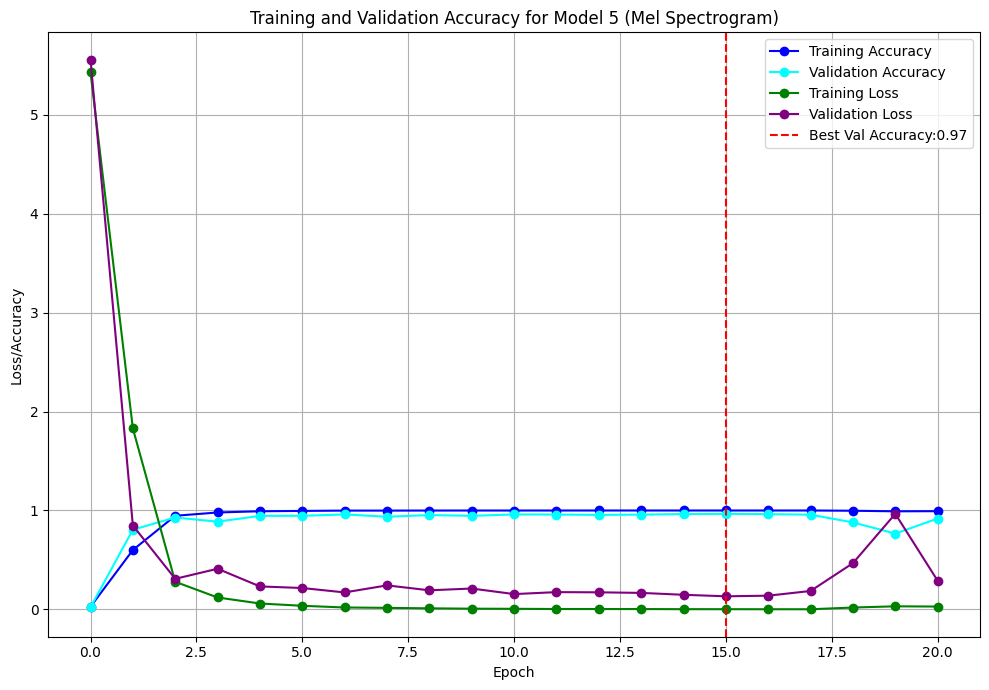

In [56]:
# Training model 5 on the mel spectrogram
history = model5.fit(x_train_mel, y_train_encoded_mel, validation_data=(x_val_mel, y_val_encoded_mel), epochs=100, batch_size=32, callbacks=[early_stopping5])

# Saving the model
model5.save('model5_mel.h5')

# Plotting the training and validation curves
plot_curves(history, 'accuracy', 'Training and Validation Accuracy for Model 5 (Mel Spectrogram)', do_save=True, save_path='model5_mel_accuracy.png')

In [ ]:
# Training model 5 on the MFCCs
history = model5.fit(x_train_mfcc, y_train_encoded_mfcc, validation_data=(x_val_mfcc, y_val_encoded_mfcc), epochs=100, batch_size=32, callbacks=[early_stopping5])

# Saving the model
model5.save('model5_mfcc.h5')

# Plotting the training and validation curves
plot_curves(history, 'accuracy', 'Training and Validation Accuracy for Model 5 (MFCCs)', do_save=True, save_path='model5_mfcc_accuracy.png')

**<h5>Training model 6 with the different feature extractors</h5>**

Epoch 1/100
246/246 [==============================] - 91s 366ms/step - loss: 5.6619 - accuracy: 0.0362 - val_loss: 4.5205 - val_accuracy: 0.0845
Epoch 2/100
246/246 [==============================] - 91s 368ms/step - loss: 2.6631 - accuracy: 0.4139 - val_loss: 1.7952 - val_accuracy: 0.5955
Epoch 3/100
246/246 [==============================] - 90s 366ms/step - loss: 0.6974 - accuracy: 0.8639 - val_loss: 0.6102 - val_accuracy: 0.8726
Epoch 4/100
246/246 [==============================] - 91s 369ms/step - loss: 0.2392 - accuracy: 0.9633 - val_loss: 0.4446 - val_accuracy: 0.9096
Epoch 5/100
246/246 [==============================] - 91s 371ms/step - loss: 0.1096 - accuracy: 0.9873 - val_loss: 0.4634 - val_accuracy: 0.8986
Epoch 6/100
246/246 [==============================] - 92s 374ms/step - loss: 0.0662 - accuracy: 0.9928 - val_loss: 0.3369 - val_accuracy: 0.9320
Epoch 7/100
246/246 [==============================] - 91s 370ms/step - loss: 0.0459 - accuracy: 0.9949 - val_loss: 0.5544 -

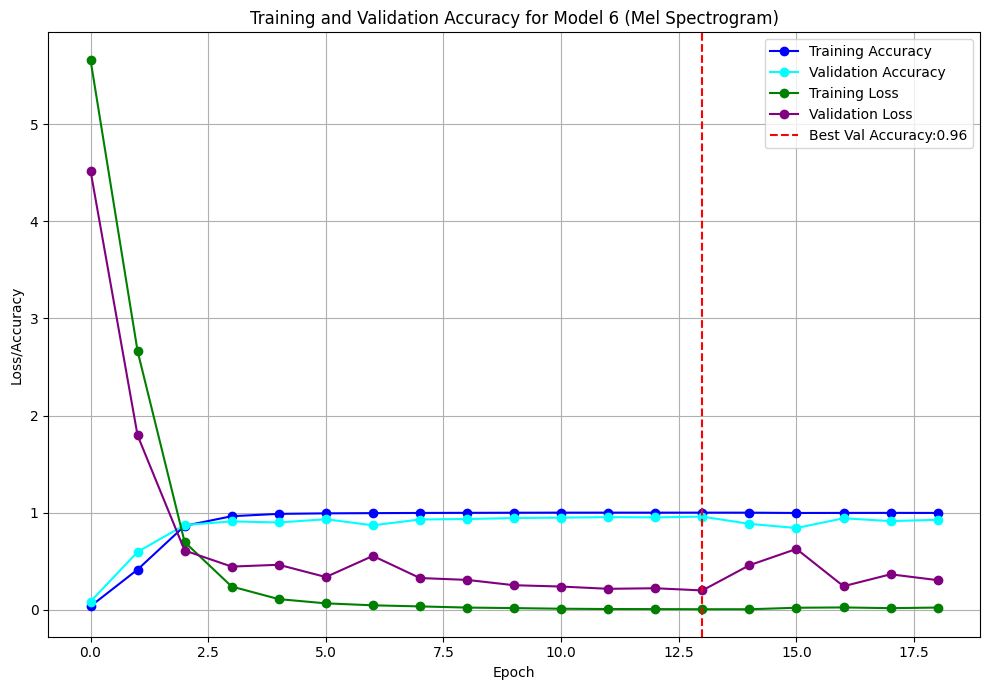

In [58]:
# Training model 6 on the mel spectrogram
history = model6.fit(x_train_mel, y_train_encoded_mel, validation_data=(x_val_mel, y_val_encoded_mel), epochs=100, batch_size=32, callbacks=[early_stopping6])

# Saving the model
model5.save('model6_mel.h5')

# Plotting the training and validation curves
plot_curves(history, 'accuracy', 'Training and Validation Accuracy for Model 6 (Mel Spectrogram)', do_save=True, save_path='model6_mel_accuracy.png')

In [ ]:
# Training model 6 on the MFCCs
history = model6.fit(x_train_mfcc, y_train_encoded_mfcc, validation_data=(x_val_mfcc, y_val_encoded_mfcc), epochs=100, batch_size=32, callbacks=[early_stopping6])

# Saving the model
model5.save('model6_mfcc.h5')

# Plotting the training and validation curves
plot_curves(history, 'accuracy', 'Training and Validation Accuracy for Model 6 (MFCCs)', do_save=True, save_path='model6_mfcc_accuracy.png')

**<h3>7. Evaluation</h3>**

**<h4>Function to display the confusion matrix for multiple labels</h4>**

In [63]:
def display_confusion_matrix(confusion_matrix, labels, title, subset=None, do_display=False, do_save=False, save_path=None):
    """Function to display the confusion matrix for multiple labels.

    Args:
        confusion_matrix (numpy.ndarray): Confusion matrix to be displayed.
        labels (list): List of label names.
        title (str): Title of the plot.
        subset (list): List of labels to be displayed (default is None).
        do_display (bool): Flag to display the plot (default is False).
        do_save (bool): Flag to save the plot (default is False).
        save_path (str): Path to save the plot (default is None).
    """
    if subset is not None:
       # Filtering the confusion matrix
        confusion_matrix = confusion_matrix[subset][:, subset]

        # Filtering the labels
        labels = [labels[i] for i in subset]

    # Setting the figure size
    plt.figure(figsize=(24, 20))

    # Saving data in a DataFrame
    df_cm = pd.DataFrame(confusion_matrix, index=labels, columns=labels)

    # Plotting the heatmap
    sns.heatmap(df_cm, annot=True, cmap='Blues', fmt='g')

    # Setting the title
    plt.title(title)

    # Saving the plot
    if do_save:
        # Saving the file in a folder called 'plots'
        if not os.path.exists('plots'):
            os.makedirs('plots')

        # Saving the plot
        plt.savefig(os.path.join('plots', save_path))

    # Displaying the plot
    if do_display:
        plt.show()
    else:
        plt.close()

**<h4>Function to calculate and display the metrics for the model</h4>**

In [71]:
def display_metrics(model, x_test, y_test_encoded, title, classes, do_display=False, do_save=False, save_path=None, subset=None):
    """Function to calculate and display the metrics for the model.

    Args:
        model (keras.models.Sequential): Model to be evaluated.
        x_test (numpy.ndarray): Testing set.
        y_test_encoded (numpy.ndarray): Encoded testing labels.
        title (str): Title of the plot.
        classes (list): List of class names.
        do_display (bool): Flag to display the metrics (default is False).
        do_save (bool): Flag to save the metrics (default is False).
        save_path (str): Path to save the plot (default is None).
        subset (list): List of labels to be displayed (default is None).
    """
    # Evaluating the model on the testing set
    test_loss, test_accuracy = model.evaluate(x_test, y_test_encoded, verbose=1)

    # Predicting the labels of the testing set
    y_pred = model.predict(x_test)

    # Converting the predictions to labels
    y_pred = np.argmax(y_pred, axis=1)

    # Converting the one-hot encoded labels to labels
    y_true = np.argmax(y_test_encoded, axis=1)

    # Calculating the confusion matrix
    cm = confusion_matrix(y_true, y_pred)

    # Calculating the precision, recall and f1 score
    precision = precision_score(y_true, y_pred, average='weighted')
    recall = recall_score(y_true, y_pred, average='weighted')
    f1 = f1_score(y_true, y_pred, average='weighted')

    # Displaying the metrics
    print('\033[35m' + 'Test Accuracy: ' + '\033[0m' + str(round(test_accuracy, 3)))
    print('\033[35m' + 'Test Loss: ' + '\033[0m' + str(round(test_loss, 3)))
    print('\033[35m' + 'Precision: ' + '\033[0m' + str(round(precision, 3)))
    print('\033[35m' + 'Recall: ' + '\033[0m' + str(round(recall, 3)))
    print('\033[35m' + 'F1 Score: ' + '\033[0m' + str(round(f1, 3)))

    # Saving the metrics in a json file
    if do_save:
        # Saving the file in a folder called 'metrics'
        if not os.path.exists('metrics'):
            os.makedirs('metrics')

        # Saving the metrics in a json file
        with open(os.path.join('metrics', save_path), 'w') as f:
            json.dump({'Test Accuracy': test_accuracy, 'Test Loss': test_loss, 'Precision': precision, 'Recall': recall, 'F1 Score': f1}, f, indent=4)

    # Displaying the confusion matrix with subset
    if subset is not None:
        display_confusion_matrix(cm, classes, title, subset=subset, do_display=do_display, do_save=do_save, save_path=save_path+'_subset')

    # Displaying confusion matrix without subset
    display_confusion_matrix(cm, classes, title, do_display=do_display, do_save=do_save, save_path=save_path)

**<h4>Calculating and displaying the metrics for all the models</h4>**

In [72]:
# Loading the model
model1_mel = keras.models.load_model('model1_mel.h5')

# Extracting the labels
classes = [speaker_root.split('\\')[-1] for speaker_root in speaker_roots]

# Displaying the metrics for model 1 on the mel spectrogram
display_metrics(model1_mel, x_test_mel, y_test_encoded_mel, 'Confusion Matrix for Model 1 (Mel Spectrogram)', classes, do_save=True, save_path='model1_mel_metrics', subset=list(range(30)))

91/91 [==============================] - 6s 60ms/step
Test Accuracy: 0.968
Test Loss: 0.148
Precision: 0.971
Recall: 0.968
F1 Score: 0.968


In [73]:
# Loading the model
model1_mfcc = keras.models.load_model('model1_mfcc.h5')

# Extracting the labels
classes = [speaker_root.split('\\')[-1] for speaker_root in speaker_roots]

# Displaying the metrics for model 1 on the MFCCs
display_metrics(model1_mfcc, x_test_mfcc, y_test_encoded_mfcc, 'Confusion Matrix for Model 1 (MFCCs)', classes, do_save=True, save_path='model1_mfcc_metrics', subset=list(range(30)))

91/91 [==============================] - 6s 63ms/step
Test Accuracy: 0.928
Test Loss: 0.301
Precision: 0.937
Recall: 0.928
F1 Score: 0.928


In [74]:
# Loading the model
model2_mel = keras.models.load_model('model2_mel.h5')

# Extracting the labels
classes = [speaker_root.split('\\')[-1] for speaker_root in speaker_roots]

# Displaying the metrics for model 2 on the mel spectrogram
display_metrics(model2_mel, x_test_mel, y_test_encoded_mel, 'Confusion Matrix for Model 2 (Mel Spectrogram)', classes, do_save=True, save_path='model2_mel_metrics', subset=list(range(30)))

91/91 [==============================] - 11s 124ms/step
Test Accuracy: 0.009
Test Loss: 5.619
Precision: 0.0
Recall: 0.009
F1 Score: 0.0


In [88]:
# Loading the model
model2_mfcc = keras.models.load_model('model2_mfcc.h5')

# Extracting the labels
classes = [speaker_root.split('\\')[-1] for speaker_root in speaker_roots]

# Displaying the metrics for model 2 on the MFCCs
display_metrics(model1_mfcc, x_test_mfcc, y_test_encoded_mfcc, 'Confusion Matrix for Model 2 (MFCCs)', classes, do_save=True, save_path='model2_mfcc_metrics', subset=list(range(30)))

91/91 [==============================] - 6s 70ms/step
Test Accuracy: 0.928
Test Loss: 0.301
Precision: 0.937
Recall: 0.928
F1 Score: 0.928


In [75]:
# Loading the model
model3_mel = keras.models.load_model('model3_mel.h5')

# Extracting the labels
classes = [speaker_root.split('\\')[-1] for speaker_root in speaker_roots]

# Displaying the metrics for model 3 on the mel spectrogram
display_metrics(model3_mel, x_test_mel, y_test_encoded_mel, 'Confusion Matrix for Model 3 (Mel Spectrogram)', classes, do_save=True, save_path='model3_mel_metrics', subset=list(range(30)))

91/91 [==============================] - 8s 81ms/step
Test Accuracy: 0.934
Test Loss: 0.262
Precision: 0.947
Recall: 0.934
F1 Score: 0.934


In [89]:
# Loading the model
model3_mfcc = keras.models.load_model('model3_mfcc.h5')

# Extracting the labels
classes = [speaker_root.split('\\')[-1] for speaker_root in speaker_roots]

# Displaying the metrics for model 3 on the MFCCs
display_metrics(model3_mfcc, x_test_mfcc, y_test_encoded_mfcc, 'Confusion Matrix for Model 3 (MFCCs)', classes, do_save=True, save_path='model3_mfcc_metrics', subset=list(range(30)))

91/91 [==============================] - 9s 95ms/step
Test Accuracy: 0.917
Test Loss: 0.343
Precision: 0.93
Recall: 0.917
F1 Score: 0.918


In [76]:
# Loading the model
model4_mel = keras.models.load_model('model4_mel.h5')

# Extracting the labels
classes = [speaker_root.split('\\')[-1] for speaker_root in speaker_roots]

# Displaying the metrics for model 4 on the mel spectrogram
display_metrics(model4_mel, x_test_mel, y_test_encoded_mel, 'Confusion Matrix for Model 4 (Mel Spectrogram)', classes, do_save=True, save_path='model4_mel_metrics', subset=list(range(30)))

91/91 [==============================] - 6s 62ms/step
Test Accuracy: 0.952
Test Loss: 0.252
Precision: 0.958
Recall: 0.952
F1 Score: 0.952


In [77]:
# Loading the model
model5_mel = keras.models.load_model('model5_mel.h5')

# Extracting the labels
classes = [speaker_root.split('\\')[-1] for speaker_root in speaker_roots]

# Displaying the metrics for model 5 on the mel spectrogram
display_metrics(model5_mel, x_test_mel, y_test_encoded_mel, 'Confusion Matrix for Model 5 (Mel Spectrogram)', classes, do_save=True, save_path='model5_mel_metrics', subset=list(range(30)))

91/91 [==============================] - 5s 48ms/step
Test Accuracy: 0.965
Test Loss: 0.141
Precision: 0.968
Recall: 0.965
F1 Score: 0.964


In [78]:
# Loading the model
model6_mel = keras.models.load_model('model6_mel.h5')

# Extracting the labels
classes = [speaker_root.split('\\')[-1] for speaker_root in speaker_roots]

# Displaying the metrics for model 6 on the mel spectrogram
display_metrics(model6_mel, x_test_mel, y_test_encoded_mel, 'Confusion Matrix for Model 6 (Mel Spectrogram)', classes, do_save=True, save_path='model6_mel_metrics', subset=list(range(30)))

91/91 [==============================] - 5s 49ms/step
Test Accuracy: 0.965
Test Loss: 0.141
Precision: 0.968
Recall: 0.965
F1 Score: 0.964
